In [1]:
# helper function to get size of a file
import os
def get_size_in_kb(file_path):
    return os.path.getsize(file_path) / 1024

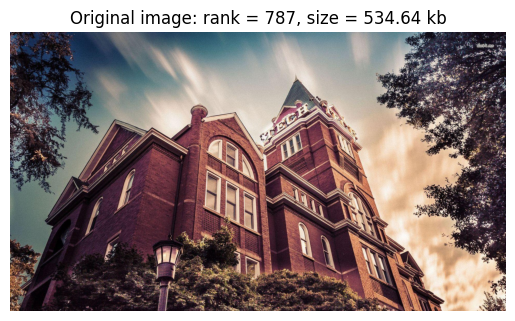

In [2]:
import matplotlib.image as image
import matplotlib.pyplot as plt

image_to_compress = image.imread("./images/tech_tower.jpg")
rows, cols, _ = image_to_compress.shape
plt.imshow(image_to_compress)
plt.title(f'Original image: rank = {min(image_to_compress.shape[0], image_to_compress.shape[1])}, size = {get_size_in_kb("./images/tech_tower.jpg"):.2f} kb')
plt.axis('off');

In [3]:
import matplotlib.image as image
from numpy.linalg import svd
import numpy as np

def svd_processing(image_path, k, save_file):
    image_to_compress = image.imread(image_path)
    rows, cols, _ = image_to_compress.shape

    R = image_to_compress[:, :, 0] / 0xff
    G = image_to_compress[:, :, 1] / 0xff
    B = image_to_compress[:, :, 2] / 0xff

    # Perform SVD on RGB channels
    R_U, R_S, R_VT = svd(R, full_matrices=True)
    G_U, G_S, G_VT = svd(G, full_matrices=True)
    B_U, B_S, B_VT = svd(B, full_matrices=True)
    
    max_rank = int(k * min(rows, cols))
    
    # Only keep first k * rank terms
    R_U_k, R_S_k, R_V_k = R_U[:, : max_rank], R_S[: max_rank], R_VT[: max_rank, :]
    G_U_k, G_S_k, G_V_k = G_U[:, : max_rank], G_S[: max_rank], G_VT[: max_rank, :]
    B_U_k, B_S_k, B_V_k = B_U[:, : max_rank], B_S[: max_rank], B_VT[: max_rank, :]

    R_compressed = np.dot(R_U_k, np.dot(np.diag(R_S_k), R_V_k))
    G_compressed = np.dot(G_U_k, np.dot(np.diag(G_S_k), G_V_k))
    B_compressed = np.dot(B_U_k, np.dot(np.diag(B_S_k), B_V_k))

    compressed_image = np.zeros((rows, cols, 3))
    compressed_image[:, :, 0], compressed_image[:, :, 1], compressed_image[:, :, 2] = R_compressed, G_compressed, B_compressed
    compressed_image[compressed_image < 0] = 0
    compressed_image[compressed_image > 1] = 1
    
    image.imsave(save_file, compressed_image)

In [4]:
from tqdm import tqdm

for i in tqdm([0.9, 0.5, 0.2, 0.05, 0.01]):
    svd_processing('./images/tech_tower.jpg', k=i, save_file=f'./compressed_images/{i}-compressed.jpg')

100%|██████████| 5/5 [00:30<00:00,  6.19s/it]


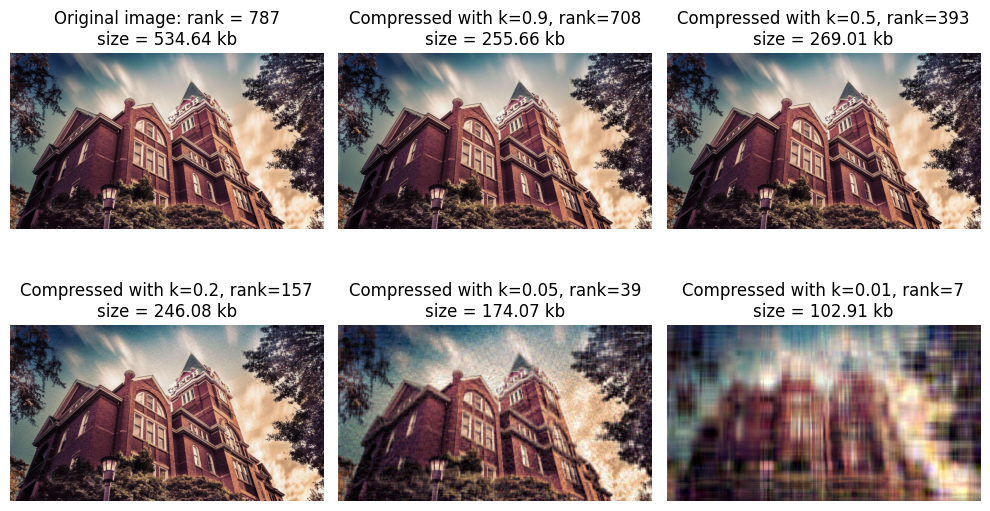

In [5]:
original_rank = min(rows, cols)
compressed_images = os.listdir('./compressed_images')

ratios = [float(img.split('-')[0]) for img in compressed_images]
compressed_images = [x for _, x in reversed(sorted(zip(ratios, compressed_images)))]

fig, axs = plt.subplots(2, 3, figsize=(10, 6))

axs[0, 0].imshow(image_to_compress) 
axs[0, 0].set_title(f'Original image: rank = {min(image_to_compress.shape[0], image_to_compress.shape[1])}\nsize = {get_size_in_kb("./images/tech_tower.jpg"):.2f} kb')
axs[0, 0].axis('off')

for i, img_file in enumerate(compressed_images):
    img = image.imread(os.path.join('./compressed_images/', img_file))
    row = (i + 1) // 3
    col = (i + 1) % 3
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    compressed_ratio = float(img_file.split("-")[0])
    axs[row, col].set_title(f'Compressed with k={compressed_ratio}, rank={int(compressed_ratio * original_rank)}' +
                            f'\nsize = {get_size_in_kb(os.path.join("./compressed_images/", img_file)):.2f} kb')
    
plt.tight_layout()
plt.show()

In [6]:
from PIL import Image
def add_noise(image_path, mean=0, std=40):
    original_image = Image.open(image_path)
    image_array = np.array(original_image)
    noise = np.random.normal(mean, std, image_array.shape)
    noisy_image = image_array + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

In [7]:
noisy_img = add_noise('./images/stadium.jpg', std=60)
svd_processing('./images/stadium.jpg', k=0.9, save_file=f'./denoised_images/{0.9}-denoised.jpg')


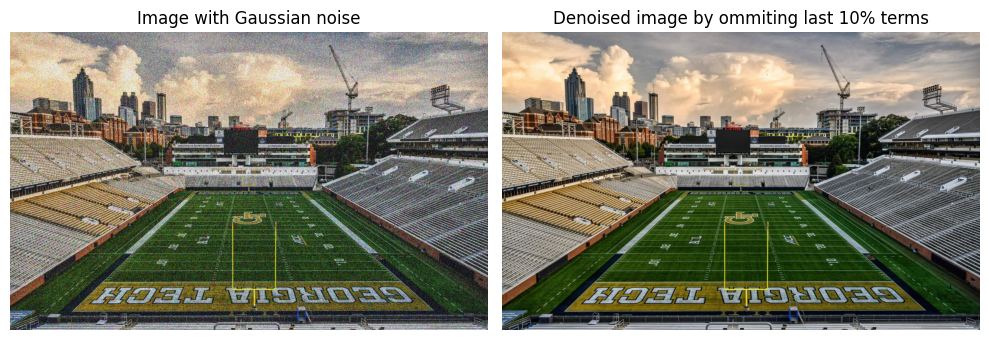

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].imshow(noisy_img) 
axs[0].set_title('Image with Gaussian noise')
axs[0].axis('off')

denoised_img = image.imread('./denoised_images/0.9-denoised.jpg')
axs[1].imshow(denoised_img) 
axs[1].set_title('Denoised image by ommiting last 10% terms')
axs[1].axis('off')
    
plt.tight_layout()
plt.show()